In [1]:
%matplotlib inline
import numpy as np

from scipy.stats import linregress
from scipy.stats import gmean, ttest_ind
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import itertools
import matplotlib.colors
import seaborn as sns
import pandas as pd
import rubisco_data

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Merge multiple measurements of the same organism by taking the median value.
merged_kin_df = rubisco_data.merge_organisms(raw_kin_df)

# Group by RuBisCO form
grouped_form = merged_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = sns.xkcd_palette(cnames)

In [3]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(raw_kin_df.species.unique().size, 'total unique species')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')
print(merged_kin_df.shape[0], 'data points post-merge')

380 total WT RuBisCOs
304 total unique species
208 RuBisCOs with all core kinetic data measured
305 data points post-merge


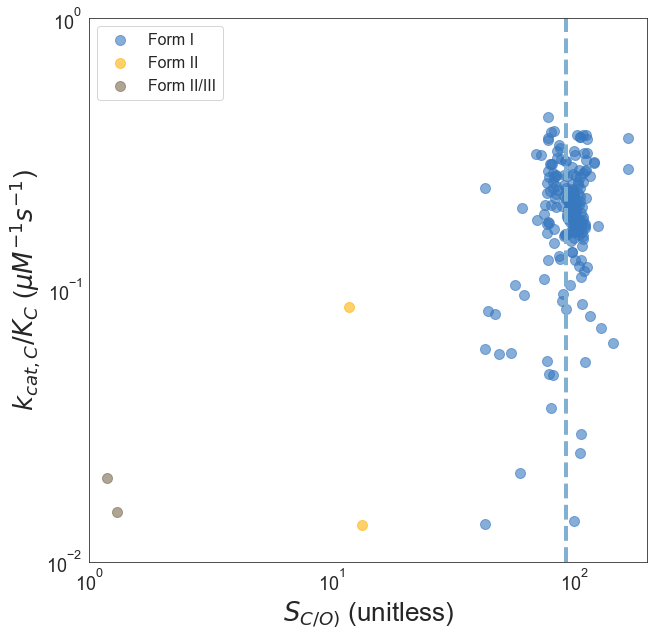

In [4]:
C = 92.614
Cmin, Cmax = 88.22922197, 95.57987783

# Mechanistic proposal #2 from Savir - k_onC vs k_onO
figure = plt.figure(figsize=(10,10))
sns.set_style('white')
colors = sns.color_palette("Set3", 8)

plt.xscale('log')
plt.yscale('log')

groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

for i, (group, gdf) in enumerate(grouped_form):
    if group == '3':
        continue
    label = 'Form %s' % groups[group]
    c = matplotlib.colors.rgb2hex(named_colors[i])
    plt.scatter(gdf.S, gdf.vC/gdf.KC,  c=c, s=100, label=label, alpha=0.6)
    
# Fit of C for all F1 data
plt.axvline(C, color=colors[4], ls='--', lw=4)
    
plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$S_{C/O)}$ (unitless)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlim(1e0, 2e2)
plt.ylim(1e-2, 1e0)

plt.savefig('fig8/fig8_konC_S.png', dpi=600)
plt.savefig('fig8/fig8_konC_S.svg')

plt.show()

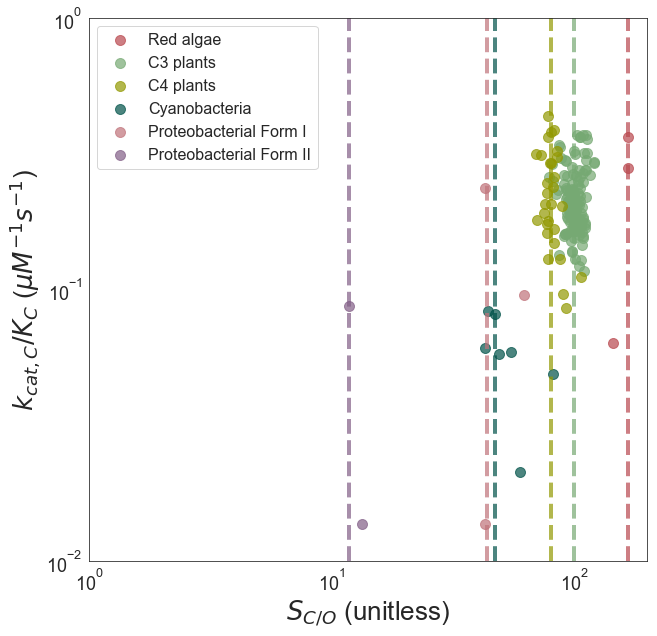

In [5]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO
figure = plt.figure(figsize=(10,10))
sns.set_style('white')

plt.xscale('log')
plt.yscale('log')

F1_data = merged_kin_df[merged_kin_df.isoform == '1']
F2_data = merged_kin_df[merged_kin_df.isoform == '2']

group_mapping = {'C3 plants': 'C3 plants',
                 'C3-C4 plants': 'C3-C4 plants',
                 'Cyanobacteria': 'Cyanobacteria',
                 'C4 plants': 'C4 plants',
                 'Green algae': 'Green algae',
                 'Red algae': 'Red algae',
                 'Alphaproteobacteria': 'Proteobacterial Form I',
                 'Betaproteobacteria': 'Proteobacterial Form I',
                 'Gammaproteobacteria': 'Proteobacterial Form I',
                }
color_mapping = {
    'C3 plants': 'dusty green',
    'C3-C4 plants': 'very light brown',
    'C4 plants': 'pea soup',
    'Cyanobacteria': 'dark blue green',
    'Green algae': 'dusty teal',
    'Red algae': 'dusty red',
    'Proteobacterial Form I': 'dusty rose',
}
grouped_taxa = F1_data.set_index('taxonomy').groupby(group_mapping)
taxa_to_plot = ['Red algae', 'C3 plants', 'C4 plants', 'Cyanobacteria', 'Proteobacterial Form I']

for i, group in enumerate(taxa_to_plot):
    gdf = grouped_taxa.get_group(group)
        
    cname = color_mapping[group]
    c = sns.xkcd_rgb[cname]
    
    plt.scatter(gdf.S, gdf.vC/gdf.KC,  c=[c], s=100, label=group, alpha=0.7)
    
    median_s = np.nanmedian(gdf.S)
    plt.axvline(median_s, color=c, ls='--', alpha=0.7, lw=4)


cname = 'dusty purple'
c = sns.xkcd_rgb[cname]
plt.scatter(F2_data.S, F2_data.vC/F2_data.KC,  c=c, s=100, label='Proteobacterial Form II', alpha=0.7)

median_s = np.nanmedian(F2_data.S)
plt.axvline(median_s, color=c, ls='--', alpha=0.7, lw=4)

    
plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$S_{C/O}$ (unitless)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlim(1e0, 2e2)
plt.ylim(1e-2, 1e0)

plt.savefig('fig8/fig8_konC_S_by_group.png', dpi=600)
plt.savefig('fig8/fig8_konC_S_by_group.svg')

plt.show()

In [6]:
conf_range = [2.5, 97.5]

for i, group in enumerate(taxa_to_plot):
    gdf = grouped_taxa.get_group(group)
    mask = gdf.S.notnull()
    S_vals = gdf[mask].S
    median_S = np.median(S_vals)
    mid95 = np.percentile(S_vals, conf_range)
    mid95_pct = 100*mid95 / median_S
    sigma_star = np.nanstd(np.log10(S_vals))
    mult_var = np.exp(np.nanstd(np.log(S_vals)))
    
    print(group)
    print('median S', median_S)
    print('middle 95%', mid95)
    print('middle 95%% as percentage of median value (%.1f%%, %.1f%%)' % (mid95_pct[0], mid95_pct[1]))
    print('sigma* %.2f' % sigma_star)
    print('multiplicative variability of S %.2f' % mult_var)
    print()

Red algae
median S 166.5
middle 95% [144.125 236.375]
middle 95% as percentage of median value (86.6%, 142.0%)
sigma* 0.09
multiplicative variability of S 1.22

C3 plants
median S 99.45
middle 95% [ 77.335 112.975]
middle 95% as percentage of median value (77.8%, 113.6%)
sigma* 0.04
multiplicative variability of S 1.10

C4 plants
median S 80.3
middle 95% [68.115 94.76 ]
middle 95% as percentage of median value (84.8%, 118.0%)
sigma* 0.04
multiplicative variability of S 1.10

Cyanobacteria
median S 47.0
middle 95% [38.875 73.775]
middle 95% as percentage of median value (82.7%, 157.0%)
sigma* 0.08
multiplicative variability of S 1.20

Proteobacterial Form I
median S 43.55
middle 95% [42.7  60.68]
middle 95% as percentage of median value (98.0%, 139.3%)
sigma* 0.07
multiplicative variability of S 1.17



Red algae 0.20531492543728538
C3 plants 0.09068107655297994
C4 plants 0.09809263617434183
Cyanobacteria 0.20584258044618317
Proteobacterial Form I 0.16978949973703525
All 0.28929727672664546


/usr/local/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


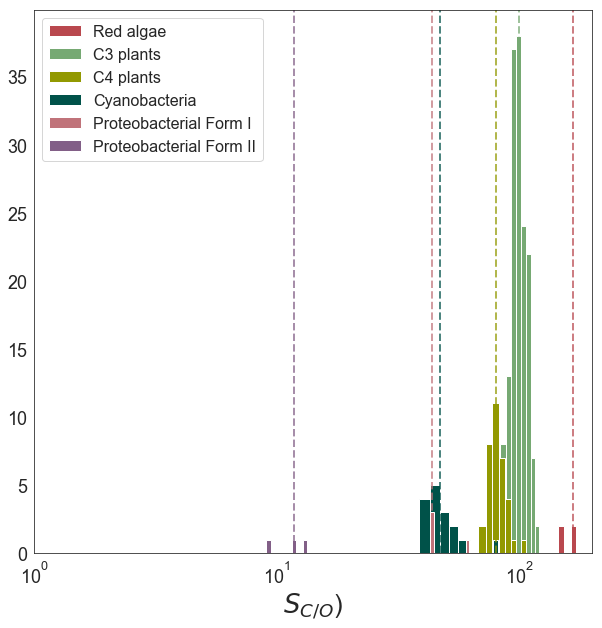

In [36]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO
figure = plt.figure(figsize=(10,10))
sns.set_style('white')

plt.xscale('log')

F1_data = merged_kin_df[merged_kin_df.isoform == '1']
F2_data = merged_kin_df[merged_kin_df.isoform == '2']

group_mapping = {'C3 plants': 'C3 plants',
                 'C3-C4 plants': 'C3-C4 plants',
                 'Cyanobacteria': 'Cyanobacteria',
                 'C4 plants': 'C4 plants',
                 'Green algae': 'Green algae',
                 'Red algae': 'Red algae',
                 'Alphaproteobacteria': 'Proteobacterial Form I',
                 'Betaproteobacteria': 'Proteobacterial Form I',
                 'Gammaproteobacteria': 'Proteobacterial Form I',
                }
color_mapping = {
    'C3 plants': 'dusty green',
    'C3-C4 plants': 'very light brown',
    'C4 plants': 'pea soup',
    'Cyanobacteria': 'dark blue green',
    'Green algae': 'dusty teal',
    'Red algae': 'dusty red',
    'Proteobacterial Form I': 'dusty rose',
}
grouped_taxa = F1_data.set_index('taxonomy').groupby(group_mapping)
taxa_to_plot = ['Red algae', 'C3 plants', 'C4 plants', 'Cyanobacteria', 'Proteobacterial Form I']

for i, group in enumerate(taxa_to_plot):
    gdf = grouped_taxa.get_group(group)
        
    cname = color_mapping[group]
    c = sns.xkcd_rgb[cname]
    
    plt.hist(gdf.S, color=c, label=group)
    median_s = np.nanmedian(gdf.S)
    cv = np.nanstd(gdf.S) / np.nanmean(gdf.S)
    print(group, cv)
    plt.axvline(median_s, color=c, ls='--', alpha=0.7, lw=2)

cv = np.nanstd(merged_kin_df.S) / np.nanmean(merged_kin_df.S)
print('All', cv)

cname = 'dusty purple'
c = sns.xkcd_rgb[cname]
plt.hist(F2_data.S, color=c, label='Proteobacterial Form II')

median_s = np.nanmedian(F2_data.S)
plt.axvline(median_s, color=c, ls='--', alpha=0.7, lw=2)

    
plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$S_{C/O}$)', fontsize=26)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlim(1e0, 2e2)

plt.show()

In [13]:
N = len(taxa_to_plot)
pvals = np.zeros((N, N))
tvals = np.zeros((N, N))

for g1, g2 in itertools.combinations(taxa_to_plot, 2):
    idx1 = taxa_to_plot.index(g1)
    idx2 = taxa_to_plot.index(g2)
    
    gdf1 = grouped_taxa.get_group(g1)
    gdf2 = grouped_taxa.get_group(g2)
    s1 = gdf1.S[gdf1.S.notnull()]
    s2 = gdf2.S[gdf2.S.notnull()]
    print('%s - %s' % (g1, g2))
    T, P = ttest_ind(s1, s2, equal_var=False)
    print('T = %.2f, P = %.2g' % (T, P))
    pvals[idx1, idx2] = P
    pvals[idx2, idx1] = P
    tvals[idx1, idx2] = T
    tvals[idx2, idx1] = T

Red algae - C3 plants
T = 4.94, P = 0.0043
Red algae - C4 plants
T = 6.00, P = 0.0018
Red algae - Cyanobacteria
T = 7.83, P = 0.00043
Red algae - Proteobacterial Form I
T = 7.70, P = 0.0003
C3 plants - C4 plants
T = 11.67, P = 2.2e-16
C3 plants - Cyanobacteria
T = 18.29, P = 9.8e-13
C3 plants - Proteobacterial Form I
T = 10.67, P = 0.0014
C4 plants - Cyanobacteria
T = 10.74, P = 1.6e-10
C4 plants - Proteobacterial Form I
T = 6.71, P = 0.004
Cyanobacteria - Proteobacterial Form I
T = 0.23, P = 0.83


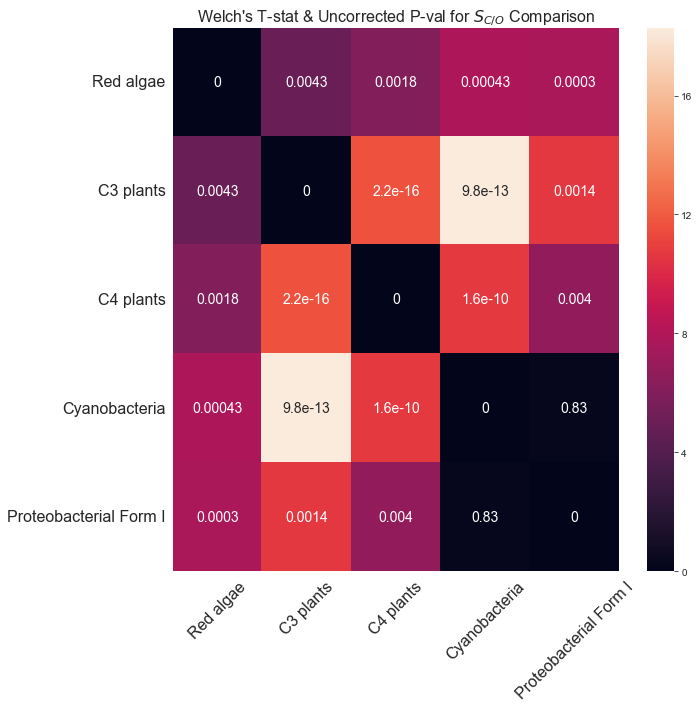

In [34]:
plt.figure(figsize=(10,10))
sns.heatmap(tvals, annot=pvals, annot_kws={'fontsize':14})
plt.yticks(np.arange(N) + 0.5, taxa_to_plot, rotation=0, va='center', fontsize=16)
plt.xticks(np.arange(N) + 0.5, taxa_to_plot, rotation=45, ha='center', fontsize=16)
plt.title("Welch's T-stat & Uncorrected P-val for $S_{C/O}$ Comparison", fontsize=16)
plt.show()

In [28]:
sns.heatmap?